<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Experiments/2d_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D CT reconstruction with sparse bvals


In [1]:
import torch
from jax import random, grad, jit, vmap
from jax.scipy import ndimage
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import os
import requests
from io import BytesIO

import cv2
import scipy.ndimage
from scipy.special import binom

from phantominator import shepp_logan, ct_shepp_logan, ct_modified_shepp_logan_params_2d

## Random seed
seed = 1287632
torch.manual_seed(seed)
rand_key = random.PRNGKey(10)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
#@markdown #Global Defaults

#@markdown resolution
RES = 512 #@param

In [3]:
import torch
import numpy as np

def _reflect_breaks(size: int) -> torch.Tensor:
    """Calculate cell boundaries with reflecting boundary conditions."""
    result = torch.cat([torch.tensor([0]), 0.5 + torch.arange(size - 1), torch.tensor([size - 1])])
    assert len(result) == size + 1
    return result

def _interval_overlap(first_breaks: torch.Tensor, second_breaks: torch.Tensor) -> torch.Tensor:
    """Return the overlap distance between all pairs of intervals."""
    first_upper = first_breaks[1:]
    second_upper = second_breaks[1:]
    upper = torch.min(first_upper[:, None], second_upper[None, :])

    first_lower = first_breaks[:-1]
    second_lower = second_breaks[:-1]
    lower = torch.max(first_lower[:, None], second_lower[None, :])

    return torch.maximum(upper - lower, torch.tensor(0.0))

def _resize_weights(old_size: int, new_size: int, reflect: bool = False) -> torch.Tensor:
    """Create a weight matrix for resizing with the local mean along an axis."""
    if not reflect:
        old_breaks = torch.linspace(0, old_size, old_size + 1)
        new_breaks = torch.linspace(0, old_size, new_size + 1)
    else:
        old_breaks = _reflect_breaks(old_size)
        new_breaks = (old_size - 1) / (new_size - 1) * _reflect_breaks(new_size)

    weights = _interval_overlap(new_breaks, old_breaks)
    weights /= torch.sum(weights, dim=1, keepdim=True)
    assert weights.shape == (new_size, old_size)
    return weights

def resize(array: torch.Tensor, shape: [int], reflect_axes: [int] = ()) -> torch.Tensor:
    """Resize an array with the local mean / bilinear scaling."""
    reflect_axes_set = set()
    for axis in reflect_axes:
        if not -array.ndim <= axis < array.ndim:
            raise ValueError('invalid axis: {}'.format(axis))
        reflect_axes_set.add(axis % array.ndim)

    output = array
    for axis, (old_size, new_size) in enumerate(zip(array.shape, shape)):
        reflect = axis in reflect_axes_set
        weights = _resize_weights(old_size, new_size, reflect=reflect)
        product = torch.tensordot(output, weights, dims=([axis], [-1]))
        output = product.movedim(-1, axis)
    return output


In [4]:
#@title Shepp Data Gen

def get_shepp_dataset(rand_key, num_grid_search_samples, test_samples):
    total_samples = num_grid_search_samples + test_samples

    ct_params = np.array(ct_modified_shepp_logan_params_2d())

    shepps = []
    for i in range(total_samples):
        rand_key, subkey = random.split(rand_key)
        i_ct_params = ct_params + random.normal(subkey, shape=ct_params.shape)/20.0
        shepps.append(np.clip(ct_shepp_logan((RES,RES), E=i_ct_params), 0.0, 1.0))

    samples = np.stack(shepps, axis=0)

    out = {
        "data_grid_search":np.array(samples[:num_grid_search_samples,:,:]),
        "data_test":np.array(samples[num_grid_search_samples:,:,:]),
    }
    return out

In [ ]:
#@title Load Datasets

visualize = True #@param {type:"boolean"}
num_grid_search_samples = 8 #@param
num_test_samples =  8#@param

#@markdown Shepp Dataset
load_shepp = True #@param {type:"boolean"}

datasets = {}
if load_shepp:
    print('Loading Shepp Dataset')
    datasets['shepp'] = get_shepp_dataset(rand_key, num_grid_search_samples, num_test_samples)
    print('Shepp Dataset Loaded')

x1 = np.linspace(0, 1, RES+1)[:-1] # use full image resolution 
x_train = np.stack(np.meshgrid(x1,x1), axis=-1)
x_test = x_train

def plot_dataset(dataset):
    plt.imshow(dataset['data_test'][0,:,:])
    plt.colorbar()
    plt.show()

if visualize:
    for dataset in datasets:
        print(f'Dataset {dataset}')
        plot_dataset(datasets[dataset])

In [32]:
print(x_train.shape)
print(x_train[250,-1,:])

(512, 512, 2)
[0.99804688 0.48828125]


In [6]:
print(datasets['shepp']['data_grid_search'].shape)
print(datasets['shepp']['data_test'].shape)

(8, 512, 512)
(8, 512, 512)


# Network setup

In [7]:
import torch
from torch import nn


network_depth = 4 #@param
network_width = 256 #@param

def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers - 1):
        layers.append(nn.Linear(num_channels, num_channels))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(num_channels, 1))
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

network = make_network(network_depth, network_width)


## Setup 2D encoder

Our 2D input embedding is of the form: \
> $\gamma(\mathbf v) = (a_0 \sin(\pi b_0^\top \mathbf v), a_0 \cos(\pi b_0^\top \mathbf v),a_1 \sin(\pi b_1^\top \mathbf v), a_1 \cos(\pi b_1^\top \mathbf v),...)$

This creates a kernel of the form: \
> $k_\gamma(\mathbf v_1, \mathbf v_2) = \sum_{i=1}^m a_i^2 \cos(\pi b_i^\top (\mathbf v_1 - \mathbf v_2))$

# CT Projection

In [24]:
import torch
import torch.nn.functional as F

def ct_project(img, theta):
    # Assume img is a torch.Tensor
    img = img.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    # Create meshgrid for coordinates
    y, x = torch.meshgrid(torch.linspace(-0.5, 0.5, img.shape[2], dtype=torch.float32),
                          torch.linspace(-0.5, 0.5, img.shape[3], dtype=torch.float32), indexing='ij')
    x_rot = x * torch.cos(theta) - y * torch.sin(theta)
    y_rot = x * torch.sin(theta) + y * torch.cos(theta)

    # Normalize coordinates for grid_sample (range [-1, 1])
    x_rot = (x_rot + 0.5) * 2 - 1
    y_rot = (y_rot + 0.5) * 2 - 1
    grid = torch.stack([x_rot, y_rot], dim=-1).unsqueeze(0)  # Add batch dimension

    # Resample image
    resampled = F.grid_sample(img, grid, mode='bilinear', padding_mode='border', align_corners=True)

    # Compute mean across height and return
    return resampled.mean(dim=2).squeeze()

def ct_project_batch(img, thetas):
    # Assume img is a tensor and thetas is a list or tensor of angles
    projections = [ct_project(img, theta) for theta in thetas]
    return torch.stack(projections, dim=0)

# Example Usage:
# img is your input image tensor with shape [H, W]
# thetas is a tensor of angles
# output = ct_project_batch(img, thetas)


# Train Model

In [27]:
import torch
from torch import nn, optim
import numpy as np
from tqdm import tqdm

cuda_id = "cuda:1"
device = torch.device(cuda_id if (torch.cuda.is_available()) else "cpu")

def train_model(lr, iters, train_data, test_data, name='', plot_groups=None):
    #train_data: (x_train, y_train, thetas, image), 
    model = make_network(network_depth, network_width).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_psnrs = []
    test_psnrs = []
    xs = []

    for i in tqdm(range(iters), desc='Training Iteration', leave=False):
        print(train_data[0] , train_data[1])
        # input = train_data[0].to(device)
        # optimizer.zero_grad()
        # predictions = model(input)
        # loss = torch.nn.functional.mse_loss(predictions, train_data[1])
        # loss.backward()
        # optimizer.step()

        # if i % 25 == 0:
        #     with torch.no_grad():
        #         test_predictions = model(test_data[0])
        #         test_psnr = calculate_psnr(test_predictions, test_data[1])
        #         train_psnrs.append(train_psnr)
        #         test_psnrs.append(test_psnr)
        #         xs.append(i)

        #         if plot_groups is not None:
        #             plot_groups['Test PSNR'].append(test_psnr)
        #             plot_groups['Train PSNR'].append(train_psnr)
        #             update_plots(plot_groups, i)

[0.         0.15707963 0.31415927 0.4712389  0.62831853 0.78539816
 0.9424778  1.09955743 1.25663706 1.41371669 1.57079633 1.72787596
 1.88495559 2.04203522 2.19911486 2.35619449 2.51327412 2.67035376
 2.82743339 2.98451302]


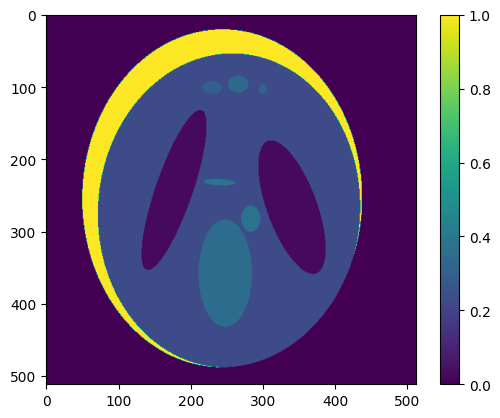

In [28]:
num_thetas = 20#@ CT projection parameters

params = {
    'shepp': {
        'lr': 1e-3,
        'no_enc_lr': 1e-2,
        'basic_lr': 1e-2,
        'gridopt_lr': 1e-1,
        'posenc_scale': 3,
        'gaussian_scale': 4,
    },
    'atlas': {
        'lr': 1e-3,
        'no_enc_lr': 1e-2,
        'basic_lr': 1e-2,
        'gridopt_lr': 1e-1,
        'posenc_scale': 5,
        'gaussian_scale': 5,
    }
}
#@title Train Models

training_steps =  1000#@param

target_distribution = "shepp" #@param ["shepp", "atlas"]

num_images =  1 #@param

thetas = np.linspace(0.0, np.pi, num_thetas+1)[:-1]

outputs = {}

# no encoding
lr = params[target_distribution]['no_enc_lr']
outputs['no_encoding'] = []
for i in range(num_images):
    image = datasets[target_distribution]['data_test'][i,:,:]
    # compute projections
    print(thetas)
    plt.imshow(image)
    plt.colorbar()
    plt.show()
    
#   y_train = ct_project_batch(image, thetas)
#   y_test = y_train # don't need extra projs for CT (performance is on recon.)
#   outputs['no_encoding'].append(train_model(lr, training_steps, 
#                                             (x_train, y_train, thetas, image), 
#                                             (x_test, y_test, thetas, image), 
#                                             name='no_encoding', plot_groups=plt_groups))

In [23]:
#@title Plot Results

bar_graph = True #@param {type:"boolean"}
image_reconstructions = True #@param {type:"boolean"}
test_img_id =  0#@param

names = list(outputs.keys())

image_test = datasets[target_distribution]['data_test'][test_img_id,:,:]

xvals = np.arange(len(names))
test_values = np.array([[outputs[n][i]['test_psnrs'][-1] for i in range(len(outputs[n]))] for n in names])
test_values_mean = np.mean(test_values, axis=-1)
test_values_std = np.std(test_values, axis=-1)
train_values = np.array([[outputs[n][i]['train_psnrs'][-1] for i in range(len(outputs[n]))] for n in names])
train_values_mean = np.mean(train_values, axis=-1)
train_values_std = np.std(train_values, axis=-1)
inds = np.argsort(test_values_mean)
names_sort = [names[i] for i in inds]

if image_reconstructions:
    print('----------------------------------------')
    print('                  Test')
    print('----------------------------------------')
    plt.figure(figsize=(28,6))
    for i, p in enumerate(names_sort):
        pred = outputs[p][0]['final_test']
        plt.subplot(1,len(names)+1,i+1)
        plt.imshow(pred)
        plt.title(p)

    plt.subplot(1,len(names)+1,len(names)+1)
    plt.imshow(image_test)
    plt.title('truth test')
    plt.show()

----------------------------------------
                  Test
----------------------------------------


/home/stan/data/anaconda3/envs/pinn/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stan/data/anaconda3/envs/pinn/lib/python3.12/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/stan/data/anaconda3/envs/pinn/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/stan/data/anaconda3/envs/pinn/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/stan/data/anaconda3/envs/pinn/lib/python3.12/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


IndexError: list index out of range

<Figure size 2800x600 with 0 Axes>

In [ ]:
np.savez('2D_CT_shepp.npz', outputs)

In [ ]:
ind = 6
pred_ne = outputs['no_encoding'][ind]['final_test']
pred_g = outputs['gaussian'][ind]['final_test']
plt.figure()
plt.imshow(pred_ne)
plt.figure()
plt.imshow(pred_g)

In [ ]:
plt.imsave('2D_CT_no_encoding.png', pred_ne, cmap='gray')
plt.imsave('2D_CT_gaussian_encoding.png', pred_g, cmap='gray')